## Лабораторная работа 5. Ансамбли моделей машинного обучения. Часть 1.

Задание:

Выберите набор данных (датасет) для решения задачи классификации или регресии.
В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
С использованием метода train_test_split разделите выборку на обучающую и тестовую.
Обучите следующие ансамблевые модели:

-две модели группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);

-AdaBoost;

-градиентный бустинг.

Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

#### Загрузка данных и предобработка

In [15]:
# Загрузка данных
df = pd.read_csv('diamonds.csv')

# Удаление неинформативного столбца
df.drop(columns=['Unnamed: 0'], inplace=True)

# Целевая переменная и признаки
X = df.drop(columns='price')
y = df['price']

# Категориальные и числовые признаки
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


In [16]:
# Числовые признаки: заполнение средними значениями
num_imputer = SimpleImputer(strategy='mean')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# Категориальные признаки: заполнение модой
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])


In [17]:
# OneHot-кодирование
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_encoded = encoder.fit_transform(X[cat_cols])

# Получение названий новых признаков
encoded_cols = encoder.get_feature_names_out(cat_cols)

# Создание датафрейма с закодированными признаками
df_encoded = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)

# Объединение с числовыми признаками
X_final = pd.concat([X[num_cols], df_encoded], axis=1)


#### Нормализация признаков: масштабирование для улучшения сходимости моделей

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Определение моделей машинного обучения

In [20]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=42),
    "Bagging Regressor": BaggingRegressor(
        estimator=DecisionTreeRegressor(), n_estimators=100,
        oob_score=True, bootstrap=True, random_state=42
    ),
    "AdaBoost": AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=50, random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
}


#### Обучение моделей и оценка их эффективности

In [21]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    oob = getattr(model, 'oob_score_', None)

    results[name] = (rmse, r2, oob)
    print(f"{name} | RMSE: {rmse:.2f} | R²: {r2:.4f} | OOB Score: {oob if oob is not None else 'N/A'}")


Random Forest | RMSE: 550.01 | R²: 0.9810 | OOB Score: 0.980371967549682
Bagging Regressor | RMSE: 549.22 | R²: 0.9810 | OOB Score: 0.9803102079253039
AdaBoost | RMSE: 1393.99 | R²: 0.8778 | OOB Score: N/A
Gradient Boosting | RMSE: 719.36 | R²: 0.9674 | OOB Score: N/A


#### Визуализация результатов: RMSE и R² по моделям

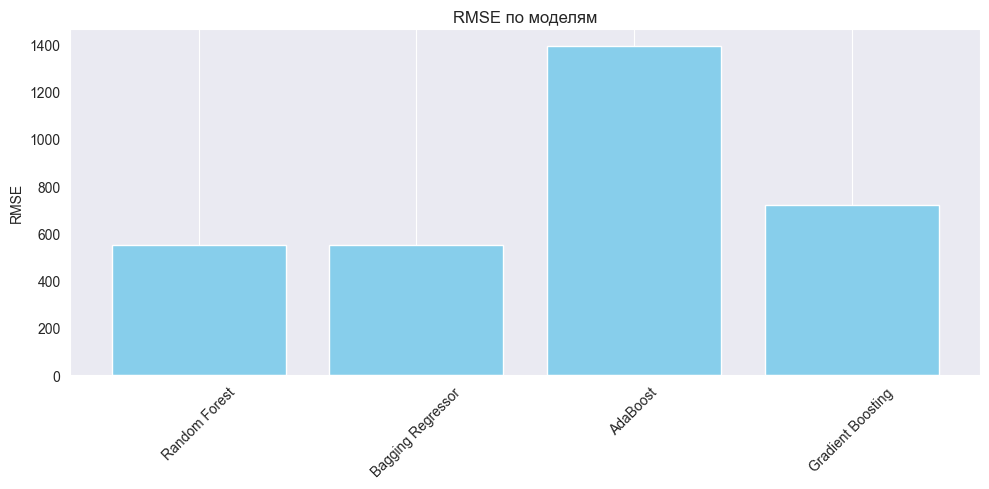

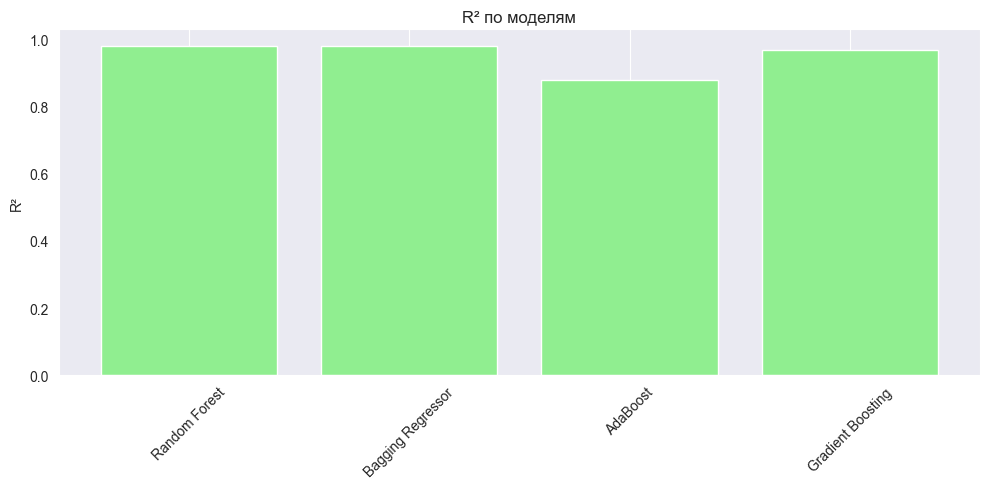

In [22]:
import matplotlib.pyplot as plt

# Список моделей, RMSE и R²
model_names = list(results.keys())
rmse_values = [results[name][0] for name in model_names]
r2_values = [results[name][1] for name in model_names]

# Визуализация RMSE
plt.figure(figsize=(10, 5))
plt.bar(model_names, rmse_values, color='skyblue')
plt.title('RMSE по моделям')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Визуализация R²
plt.figure(figsize=(10, 5))
plt.bar(model_names, r2_values, color='lightgreen')
plt.title('R² по моделям')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


####  Визуализация фактических vs предсказанных значений для каждой модели

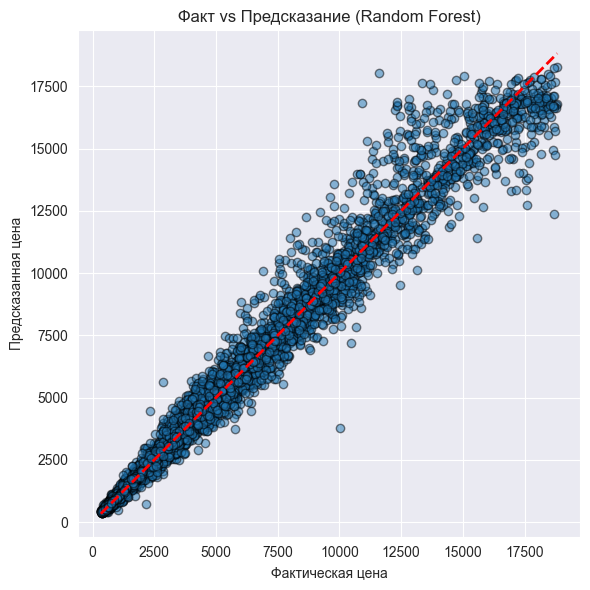

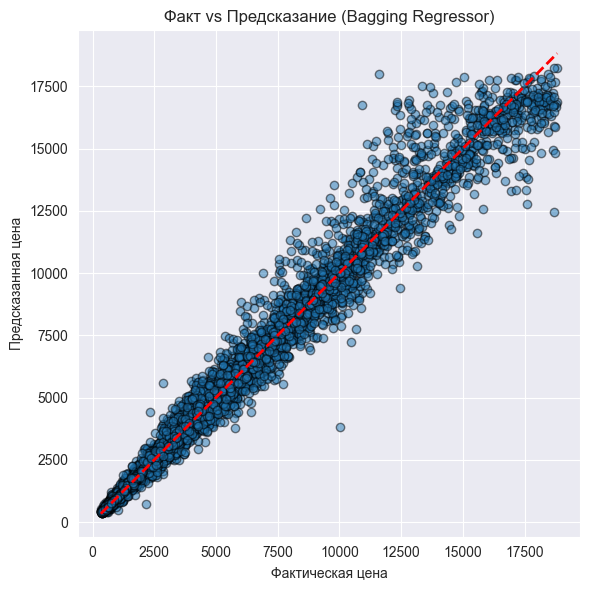

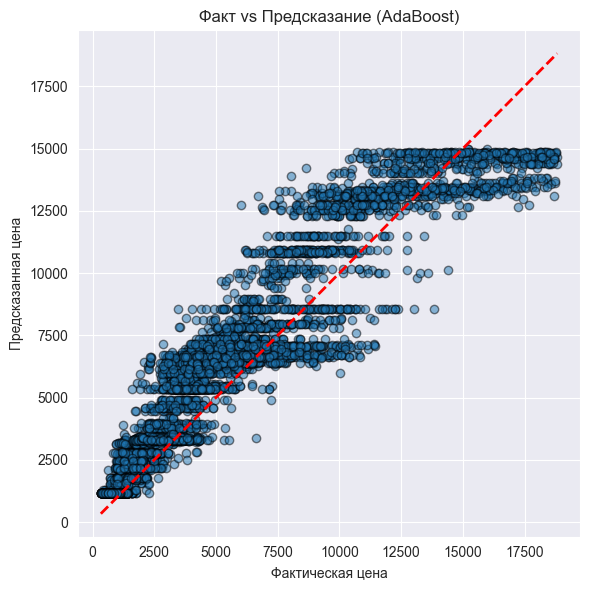

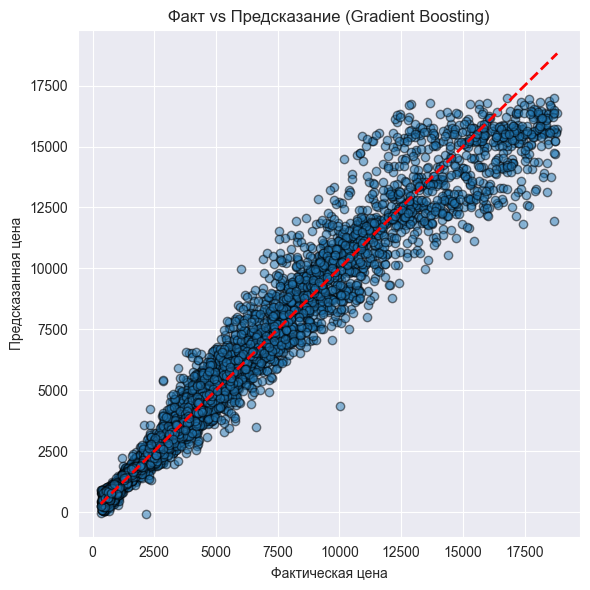

In [23]:
for name, model in models.items():
    y_pred = model.predict(X_test)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактическая цена')
    plt.ylabel('Предсказанная цена')
    plt.title(f'Факт vs Предсказание ({name})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Визуализация важности признаков для моделей

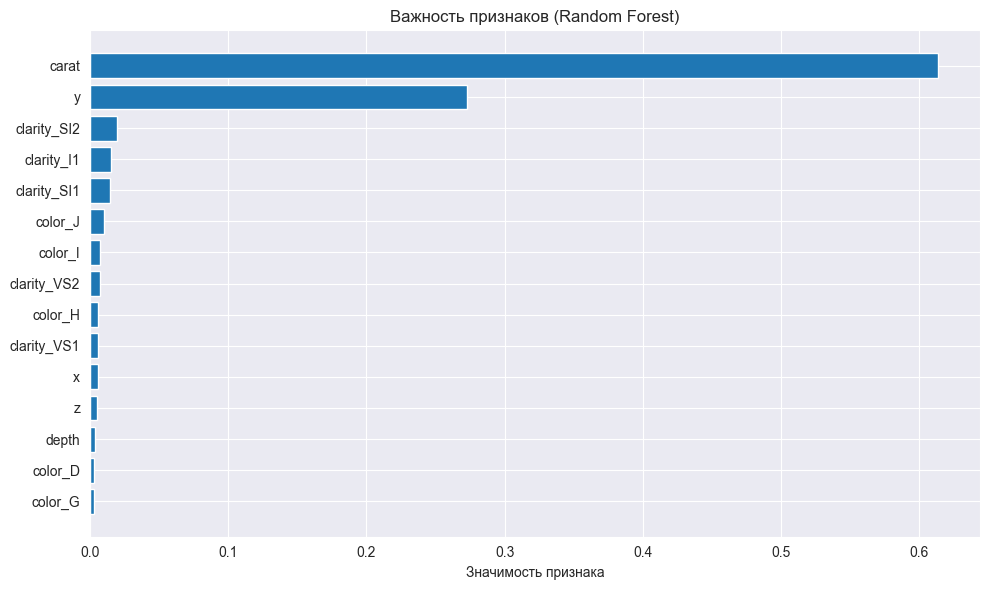

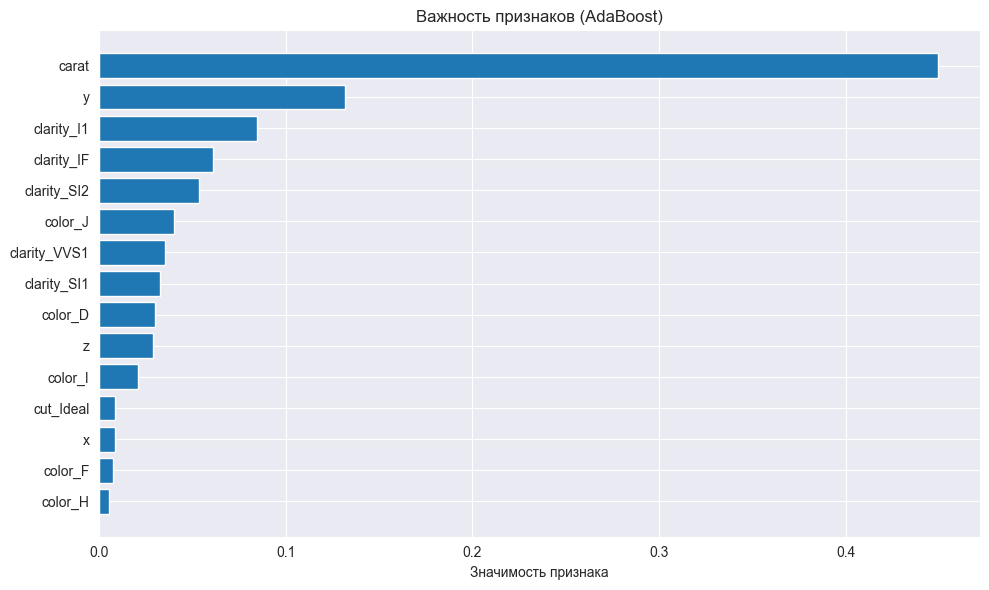

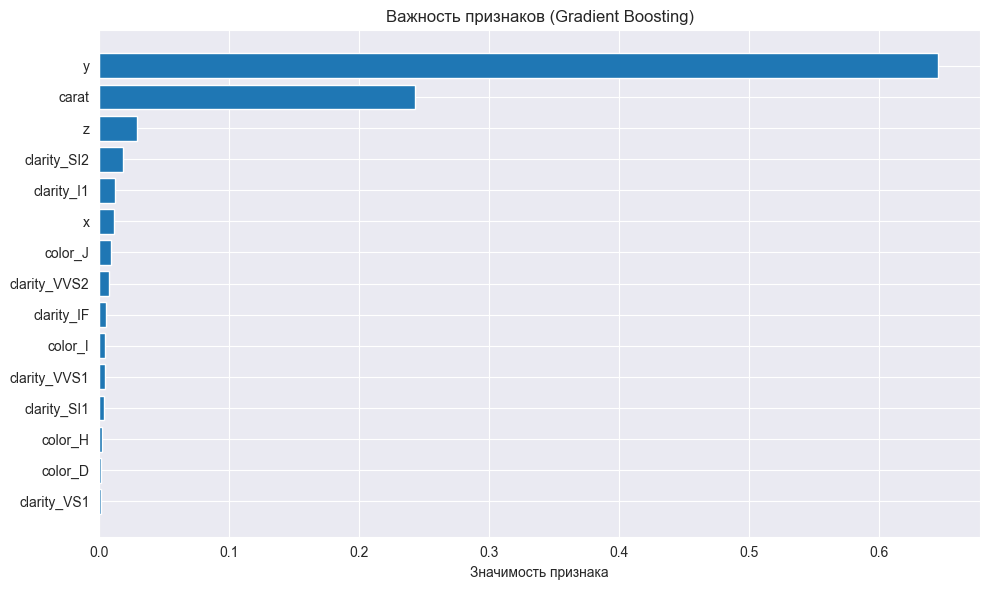

In [24]:
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-15:]  # топ-15 признаков

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), np.array(X_final.columns)[indices])
        plt.xlabel('Значимость признака')
        plt.title(f'Важность признаков ({name})')
        plt.tight_layout()
        plt.show()
